In [1]:
from imp import reload
import sys
print(sys.version)
# import rpy2
import os
import os.path
import glob
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# Use Type 1 fonts in plots.
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm

3.7.5 (default, Nov  1 2019, 02:16:23) 
[Clang 11.0.0 (clang-1100.0.33.8)]


# Plotting the results of the experiments in the paper 
## Which value of $r_1$ (ratio_samples_learn) and $r_2$ (weight_samples_learn) is the best for each instance?

The learning rate $\rho$ (uBorda parameter) is **not** set manually. Instead, we use these two parameters to obtain a more interpretable setting: The value of $\rho$ is set at each iteration and depends on the set of function evaluations $F$. Parameter $\rho$ is set such that the largest $r_1$\% of the mass of the weights is concentrated in the best $r_2$\% of the solutions in $S$, i.e., 

$$
r_1 \sum_{\sigma\in S}\rho^{f(\sigma)} =  \sum_{\sigma\in S'}\rho^{f(\sigma)} \text{where} |S'| = r_2|S| \land \forall \sigma'\in S', \sigma\in S\setminus S' : f(\sigma')\geq f(\sigma)
$$


Therefore, for each instance, we plot the mean of the best fitnesses over 10 repetitions as a function of $r_1$ and $r_2$. Since we are minimizing, the lower the better. 

Overall, the values ($r_1, r_2$)=(.1,.9) have good performance, we will use this configuration for the rest of the experimental section. 

For the LOP instances (synthetic and real) the best fitness function changes smoothly when we change the parameters
For the QAP and PFSP this does not happen, meaning that the convergence to the optimal is not smooth

The following two cells perform the experiments, in particular:
- the first one run the whole combination of parameters (beware that this takes long because they are lots of executions) and we do not recomment to run here and
- the second one processes the results and generates the plots

In [3]:
# dfselected = pd.read_csv('./best_fitness_selected.txt',sep='\t')
# lis = []
# for inst in dfselected.instance_name.values:#collect all the instance paths
#   for folder in ['./lop/','./pfsp/', './qap/']: 
#       for dirpath, dirnames, filenames in os.walk(folder):
#           for filename in [f for f in filenames ]:
#             if inst in os.path.join(dirpath, filename):
#                 lis.append(os.path.join(dirpath, filename))    
# budget=40#0
# m_ini=10
# budgetMM=10
# res = []
# for instance_name in lis:
#   for r1 in [.1,.2,.3,.4,.5]:
#     for r2 in [.6,.7,.8,.9,.99]:
#       for seed in range(1):
#         out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
#         df = runner.run_once("UMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, 
#                              ratio_samples_learn = r1, weight_mass_learn = r2, out_filename = out_filename)
#         print(out_filename,r1, r2,df.Fitness.min())
#         res.append([out_filename,ratio_samples_learn, weight_mass_learn,df.Fitness.min()])
#         #os.remove(out_filename)

N-atp111


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


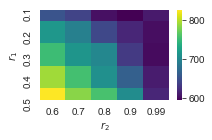

N-atp134


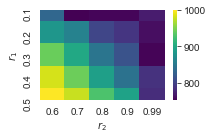

N-be75eec-150


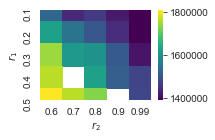

N-be75np-150


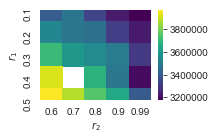

N-p50-01


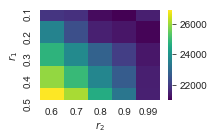

N-p50-02


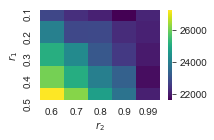

N-t1d100.01


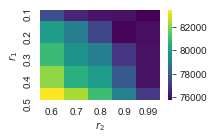

N-t1d100.02


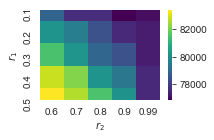

N-t1d150.01


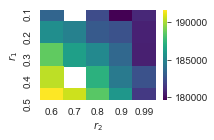

N-t1d150.02


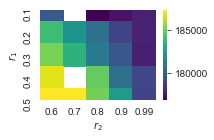

N-t2d150.01


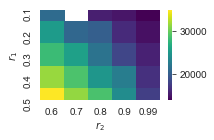

N-t2d150.02


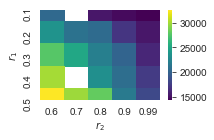

kra32.dat


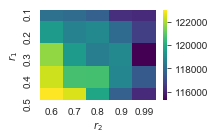

nug12.dat


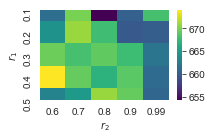

nug30.dat


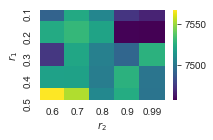

rec05


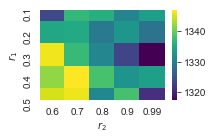

rec13


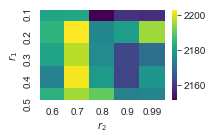

rec19


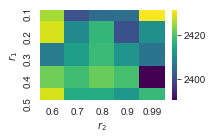

rec31


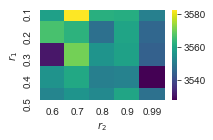

tho30.dat


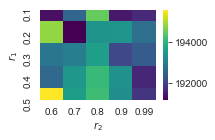

In [2]:
df = pd.read_csv('results/results.csv',index_col=0)
df.columns = [c if c!='min' else 'best' for c in df.columns]
df = pd.pivot_table(df,index=['filename','ratio','weight'],values='best',aggfunc={np.mean,np.min, np.std})#.reset_index()
df.columns = ['best_'+ c for c in df.columns]
dfres = df.reset_index()
dfres
for instance_name in dfres.filename.drop_duplicates().values:
    print(instance_name, )
    plt.figure(figsize=(3,2))
    sns.set_style("whitegrid")
    square = dfres[dfres.filename == instance_name].pivot_table(index='ratio', columns='weight', values='best_mean')
    sns.heatmap(square, cmap="viridis")
    plt.tight_layout()
    plt.xlabel(r'$r_2$')
    plt.ylabel(r'$r_1$')
    plt.savefig('img/heatmap_'+instance_name.replace('.','_')+'.pdf')
    plt.show()

## Synthetic datasets (LOP)


  The instances $M$ follow this distribution $M_\phi[i,j]$
  $$M_\phi[i,j] = h(j-i+1,\phi) - h(j-i,\phi),$$ where $$h(k,\phi)=\frac{k}{1-\phi^k} \enspace.$$
  
Taking different values of $\phi$ we controll the uniformity of $M$.
  
In the next cell we plot the results over the synthetic instances

In [2]:
# Compare synthetic data in the same plot.
# Compare the convergence to lowest fitness funtion values by the two solvers
# MANUEL: Can we read it in one go?
lis = []
for filename in glob.glob("./results/LOP-synthetic*/*.pkl.gz"):
    lis.append(pd.read_pickle(filename))
df = pd.concat(lis)
df['Uniformity'] = df.instance.str[-3:].astype(float)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 0 to 399
Data columns (total 18 columns):
Distance                24000 non-null float64
Fitness                 24000 non-null float64
Function evaluations    24000 non-null int64
Problem                 24000 non-null object
Solver                  24000 non-null object
budget                  24000 non-null int64
budgetGA                12000 non-null float64
budgetMM                12000 non-null float64
instance                24000 non-null object
m_ini                   24000 non-null int64
phi_estim               11700 non-null float64
phi_sample              11700 non-null float64
ratio_samples_learn     12000 non-null float64
rho                     11700 non-null float64
run_time                24000 non-null float64
seed                    24000 non-null int64
weight_mass_learn       12000 non-null float64
x                       24000 non-null object
dtypes: float64(10), int64(4), object(4)
memory usage: 3.5+

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [11]:
df['Uniformity'] = df.instance.str[-3:].astype(float)

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


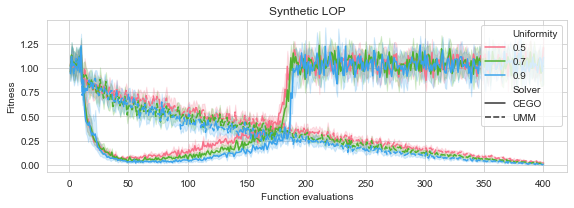

In [12]:
color_variable = 'Uniformity'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(8,3))
    g = sns.lineplot(x='Function evaluations',y=y_variable,style='Solver', hue=color_variable,data=df, palette=palette)
    g.set_title('Synthetic LOP')
    plt.tight_layout()
    plt.savefig('img/synthetic_LOP_combined.pdf')
    plt.show()

## Real datasets (LOP, QAP, PFSP)
In the following lines we load the results of the real dataset for CEGO and UMM, plot the results and make the comparison table

In [2]:
lis = []
for folder in ['results/lop/','results/pfsp/', 'results/qap/']: 
    for dirpath, dirnames, filenames in os.walk(folder):
        for filename in [f for f in filenames if f.endswith(".pkl.gz")]:
            lis.append(pd.read_pickle(os.path.join(dirpath, filename)))
df = pd.concat(lis)
dfcego = df[df.Solver=='CEGO']
dfumm = df[df.Solver=='UMM']
# dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl.gz'in filename])
# dfumm['instance'] = dfumm['instance'].str[2:] # to remove the initial ./


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Instance:  rec31
Saving to img/fitness_real_pfsp_rec31_txt.pdf


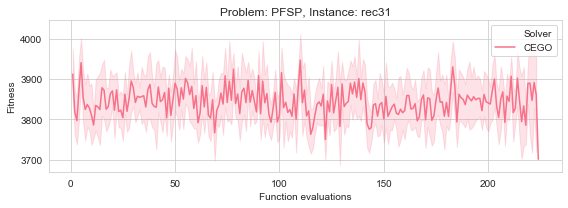

In [4]:
dfselected = pd.read_csv('./best_fitness_selected.txt',sep='\t')
dfselected
for inst in ['rec31']:#dfselected.instance_name.values:#['rec31']:#
  print("Instance: ", inst)
  df = pd.concat([dfumm[dfumm.instance.str.contains(inst)], dfcego[dfcego.instance.str.contains(inst)]],sort=False)
  if len(df) > 0:
    plt.figure(figsize=(8,3))
    palette = sns.color_palette("husl", len(df['Solver'].drop_duplicates()))
    g = sns.lineplot(x='Function evaluations',y='Fitness',hue='Solver',data=df, palette=palette)
    g.set_title('Problem: '+df.Problem.iloc[0]+', Instance: '+ inst)
    plt.tight_layout()
    filename = 'img/fitness_real_'+df.instance.iloc[0].replace('/','_').replace('.','_')+'.pdf'
    print("Saving to " + filename)
    plt.savefig(filename)
    plt.show()


In [17]:
dfcego[dfcego.Instance.str.contains('31')]

AttributeError: 'DataFrame' object has no attribute 'Instance'

## Summary of the results

Table with the summary of the results

In [9]:
# MANUEL: Why max() then mean?
# Isn't this enough?
# dfcego.groupby(['Problem','instance'])['run_time'].mean().reset_index()
a = dfcego.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
a['run_time'] = (a['run_time']/3600).round(1)
a.columns = ['Problem','instance','CEGO Runtime']
b = dfumm.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
b['run_time'] = (b['run_time']/3600).round(1)
b.columns = ['Problem','instance','UMM Runtime']
dftime = pd.merge(b,a)

a = dfcego.groupby(['Problem','instance','seed'])['Function evaluations'].max().groupby(['Problem','instance']).mean().reset_index()

a.columns = ['Problem','instance','CEGO F. evaluations']
dftime = pd.merge(dftime,a)
a = dfcego.groupby(['Problem','instance','seed']).Fitness.min()
b = dfumm.groupby(['Problem','instance','seed']).Fitness.min()
aa = a.groupby(['Problem','instance']).agg(Fitness_CEGO_mean='mean', Fitness_CEGO_std='std').reset_index() 
bb = b.groupby(['Problem','instance']).agg(Fitness_UMM_mean='mean', Fitness_UMM_std='std').reset_index() 
df = pd.merge(aa,bb)
aa = a.reset_index()
bb = b.reset_index()
for inst in df.instance:
  x,y = aa[aa.instance==inst].Fitness.values,bb[bb.instance==inst].Fitness.values
  cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
  df.loc[df.instance==inst,'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))
df['CEGO fitness'] = df.Fitness_CEGO_mean.round(1).astype(str)+" ("+df.Fitness_CEGO_std.round(1).astype(str)+")"
df['UMM fitness'] = df.Fitness_UMM_mean.round(1).astype(str)+" ("+df.Fitness_UMM_std.round(1).astype(str)+")"
df = df.drop(['Fitness_CEGO_mean'	,'Fitness_CEGO_std',	'Fitness_UMM_mean',	'Fitness_UMM_std'], axis=1)
df = pd.merge(df,dftime, on=['Problem', 'instance'])
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df = df[['Problem', 'Instance','UMM fitness', 'CEGO fitness',	'Confidence interval',	'UMM Runtime',	'CEGO Runtime',	'CEGO F. evaluations']]
df


,Problem,Instance,UMM fitness,CEGO fitness,Confidence interval,UMM Runtime,CEGO Runtime,CEGO F. evaluations
0,LOP,N-t1d100.01,76499.3 (1099.7),78012.0 (432.1),"(696.4, 2329.0)",1.9,145.1,158.3
1,LOP,N-t1d100.02,76860.7 (864.0),78834.0 (477.8),"(1303.8, 2642.8)",1.8,144.7,156.0
2,LOP,N-t1d150.01,179615.6 (1731.5),186969.0 (2094.6),"(5543.3, 9163.5)",4.4,145.7,103.9
3,LOP,N-t1d150.02,177524.2 (1165.6),183414.7 (779.2),"(4949.2, 6831.8)",4.6,145.3,103.6
4,LOP,N-t1d200.01,323501.4 (1385.7),333804.1 (1191.9),"(9086.4, 11519.0)",7.6,145.4,77.7
5,LOP,N-t1d200.02,319786.2 (2265.6),331730.9 (2819.7),"(9533.6, 14355.8)",7.1,145.9,78.2
6,LOP,N-t2d150.01,15136.9 (745.9),22207.3 (1667.3),"(5817.1, 8323.7)",4.5,145.5,104.5
7,LOP,N-t2d150.02,14718.4 (677.5),22036.0 (744.7),"(6648.3, 7986.9)",4.5,145.0,103.1
8,LOP,N-t2d200.01,33389.0 (1984.0),54043.6 (1477.6),"(19001.4, 22307.8)",7.4,146.7,78.2
9,LOP,N-t2d200.02,35589.0 (2319.6),52787.0 (4194.2),"(13948.0, 20448.0)",7.5,145.7,78.9


In [22]:
print(df.to_latex(index=False))

\begin{tabular}{lllllrrr}
\toprule
Problem &       Instance &           UMM fitness &           CEGO fitness &     Confidence interval &  UMM Runtime &  CEGO Runtime &  CEGO F. evaluations \\
\midrule
    LOP &    N-t1d100.01 &       76119.6 (915.4) &        78012.0 (432.1) &        (1199.9, 2584.9) &          3.2 &         145.1 &                158.3 \\
    LOP &    N-t1d100.02 &       76827.7 (891.0) &        78834.0 (477.8) &        (1319.6, 2693.0) &          3.2 &         144.7 &                156.0 \\
    LOP &    N-t1d150.01 &     179508.3 (1647.9) &      186969.0 (2094.6) &        (5683.0, 9238.4) &          6.5 &         145.7 &                103.9 \\
    LOP &    N-t1d150.02 &     177592.8 (1196.2) &       183414.7 (779.2) &        (4862.2, 6781.6) &          6.5 &         145.3 &                103.6 \\
    LOP &    N-t1d200.01 &     323513.6 (1371.2) &      333804.1 (1191.9) &       (9081.7, 11499.3) &         10.7 &         145.4 &                 77.7 \\
    LOP &    N

### Plot of computation times ###

In [13]:
umm_runtime = (dfumm.groupby("instance")["run_time"].mean()/3600.0).round(1).reset_index()
cego_runtime = (dfcego.groupby("instance")["run_time"].mean()/3600.0).round(1).reset_index()
run_time = pd.merge(umm_runtime,cego_runtime, on="instance", suffixes=['_umm','_cego'])
run_time


,instance,run_time_umm,run_time_cego
0,lop/RandA1/N-t1d100.01,3.2,145.1
1,lop/RandA1/N-t1d100.02,3.2,144.7
2,lop/RandA1/N-t1d150.01,6.5,145.7
3,lop/RandA1/N-t1d150.02,6.5,145.3
4,lop/RandA1/N-t1d200.01,10.7,145.4
5,lop/RandA1/N-t1d200.02,10.6,146.0
6,lop/RandA2/N-t2d150.01,7.0,145.5
7,lop/RandA2/N-t2d150.02,7.1,145.0
8,lop/RandA2/N-t2d200.01,11.2,146.7
9,lop/RandA2/N-t2d200.02,11.2,145.7
